In [63]:
import math

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import noisereduce as nr
# Audio params
SAMPLE_RATE = 22050 # (samples/sec)
DURATION = 5.0 # duration in second (sec)
AUDIO_LEN = int(SAMPLE_RATE * DURATION) # total number of samples in DURATION

# Spectrogram params
N_MELS = 128 # freq axis, number of filters
N_FFT = 2048 # frame size
HOP_LEN = 512 # non-overlap region, which means 1/4 portion overlapping
SPEC_WIDTH = AUDIO_LEN//HOP_LEN + 1 # time axis I see it comes from 80000 / HOP_LEN + 1
FMAX = SAMPLE_RATE//2 # max frequency, based on the rule, it should be half of SAMPLE_RATE
SPEC_SHAPE = [N_MELS, SPEC_WIDTH] # expected output spectrogram shape


def load_audio(filepath, sr=SAMPLE_RATE): # load the audio
    audio, sr = librosa.load(filepath, sr=sr)
    return audio, sr

def plot_audio(audio, sr=SAMPLE_RATE): # pic in time domain
    fig = librosa.display.waveshow(audio, axis='time', sr=sr)
    return fig

def get_spectrum(audio, sr=SAMPLE_RATE): # pic in frequency domain
    sp = np.fft.fft(audio)
    ampSP = np.abs(sp)
    
    # Calculate the frequency axis
    freq_axis = np.fft.fftfreq(len(sp), 1/sr)
    
    # the magnitude spectrum
    fig = plt.plot(freq_axis[:len(freq_axis)//2], ampSP[:len(freq_axis)//2])  # Only plot the positive frequencies
    return fig

def listen_audio(audio, sr=SAMPLE_RATE): # listen audio file
    display(ipd.Audio(audio, rate=sr))
    
def get_mel_spectrogram(audio, sr=SAMPLE_RATE): # get the mel-spectrogram
    # same as ######
    # s_audio = librosa.stft(audio, hop_length=HOP_LEN, n_fft=N_FFT)
    # D = np.abs(s_audio)**2 # turn complex type into float type 
    # spec = librosa.feature.melspectrogram(S=D, sr=sr) # input is spec data
    ################
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, fmax=FMAX, n_mels=N_MELS, hop_length=HOP_LEN, n_fft=N_FFT)
    spec = librosa.power_to_db(spec) # turn into log-scale
    return spec

def plot_mel_spectrogram(spec, sr=SAMPLE_RATE): # get the display fig of mel-spectrogram
    # In paper, viridis - blue to green to yellow -> best performing
    # yellow: larger / blue: smaller
    fig = librosa.display.specshow(spec, x_axis='time', y_axis='mel', n_fft=N_FFT, hop_length=HOP_LEN, sr=sr, fmax=FMAX, cmap='viridis')
    
    return fig

def plot_all(audio): 
    
    print('# Listen')
    listen_audio(audio)

    print("# Plot\n")
    plt.figure(figsize=(18, 5))

    plt.subplot(121)
    plot_audio(audio)
    plt.title("Waveform",fontsize=17)

    plt.subplot(122)
    get_spectrum(audio)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Magnitude Spectrum')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    spec = get_mel_spectrogram(audio) 
    
    plot_mel_spectrogram(spec)
    plt.title("Spectrogram",fontsize=17)
    plt.show()

# data preprocessing
# use threshold to delete the low-volume data
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),
                       min_periods=1,
                       center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

# Min-Max normalize
def normalize_audio(audio):
    return (audio - np.min(audio)) / (np.max(audio) - np.min(audio))

def denoise(audio, sr=SAMPLE_RATE):
    reduced_noise = nr.reduce_noise(y=audio, sr=SAMPLE_RATE, stationary=True, prop_decrease = 0.95, n_fft = N_FFT)
    return reduced_noise

In [65]:
print(AUDIO_LEN // HOP_LEN + 1)

216


In [66]:
print(SPEC_WIDTH)

216


### New hop_length, sr

Test on output.wav


[  2.0852838  -3.4327903 -16.945631  -24.51496   -25.655361  -27.989208
 -29.259012  -30.575197  -32.274483  -32.69208   -33.579353  -33.877853
 -34.32637   -35.833763  -36.168343  -36.84752   -37.900414  -37.87718
 -38.08661   -40.182873  -38.116135  -40.312458  -40.579407  -40.912685
 -40.326344  -41.558784  -40.711823  -42.99781   -38.355255  -40.639835
 -43.12726   -42.8982    -43.233185  -43.467766  -42.23716   -43.465202
 -44.67109   -44.477177  -45.07554   -43.735596  -43.589798  -45.789574
 -44.478806  -45.36994   -47.43897   -45.41835   -45.604546  -46.560383
 -47.978916  -46.919613  -47.650772  -45.78762   -46.93569   -42.66983
 -45.459675  -46.772232  -47.629436  -47.937008  -46.01947   -43.97669
 -42.871346  -42.640396  -42.62496   -42.50212   -41.805077  -42.005333
 -42.22663   -42.270668  -42.410225  -43.43378   -42.769966  -43.947445
 -44.638042  -45.147232  -45.814583  -48.357204  -48.751793  -47.671295
 -48.215595  -47.5226    -48.202915  -48.203545  -49.782875  -49.38

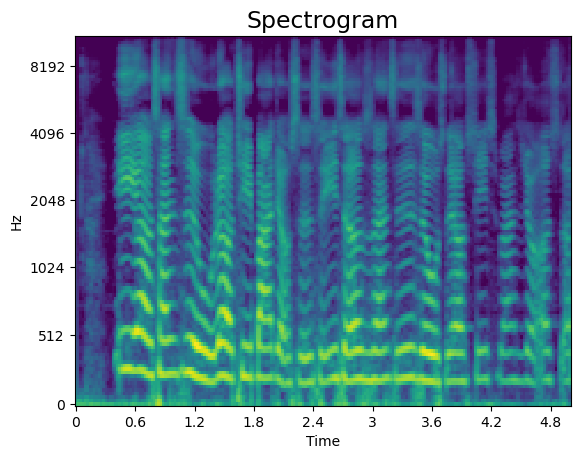

In [67]:
audio, sr = load_audio(r"output.wav", sr=SAMPLE_RATE)
# print(audio[:20])
# print(len(audio))
audio = audio[:AUDIO_LEN]
spec = get_mel_spectrogram(audio)
print(spec[:,1])
print(spec.shape) # (128, 216) = (N_MELS, samples // HOP_LENGTH + 1)

fig = plot_mel_spectrogram(spec)
plt.title("Spectrogram", fontsize=17)
plt.show()

#### 從文字檔讀取數值去繪圖

In [68]:
# Function to read Mel spectrogram from .txt file
def read_mel_spectrogram_from_txt(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        mel_spec = []
        for line in lines:
            mel_spec.extend([float(value) for value in line.split()])
    # Assuming the Mel spectrogram was stored in a flattened 1D array
    num_mels = N_MELS  # or your actual number of Mel bands
    num_frames = len(mel_spec) // num_mels
    # mel_spec = np.array(mel_spec).reshape((num_mels, num_frames))

    mel_spec = np.array(mel_spec).reshape((num_frames, num_mels)).T  # Transpose to get (num_mels, num_frames)
    print(mel_spec.shape)
    return mel_spec

# Function to plot Mel spectrogram
def plot_mel_spectrogram_txt(spec, sr=SAMPLE_RATE, hop_length=HOP_LEN, fmax=FMAX, n_fft = N_FFT):
    # plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, x_axis='time', y_axis='mel', n_fft=N_FFT, hop_length=HOP_LEN, sr=sr, fmax=FMAX, cmap='viridis')
    # plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

From C++ code, plot by "mel_spectrogra_latest.txt" file
(128, 216)


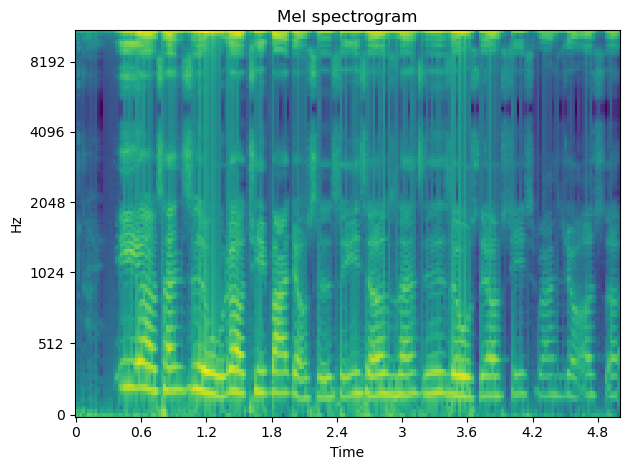

From C++ code, plot by "mel_spectrogram.txt" file
(128, 216)


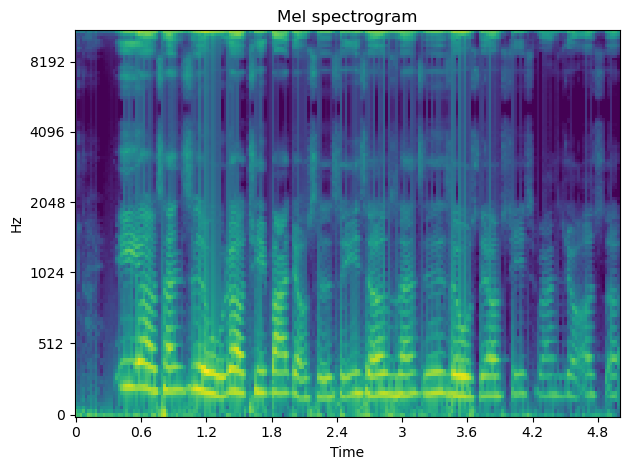

From C++ code, plot by "mel_spectrogram_fix_mel_bank.txt" file
(128, 216)


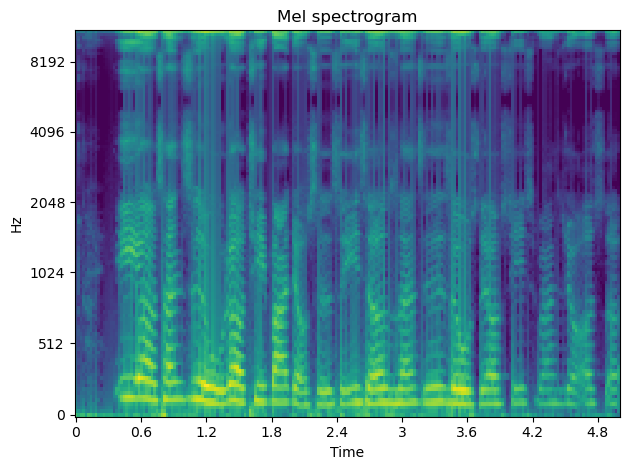

In [69]:
# Example usage
file_path = 'mel_spectrogra_latest.txt'  # Replace with your actual file path
print(f"From C++ code, plot by \"{file_path}\" file")
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

# Example usage
file_path = 'mel_spectrogram.txt'  # Replace with your actual file path
print(f"From C++ code, plot by \"{file_path}\" file")
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

# Example usage
file_path = 'mel_spectrogram_fix_mel_bank.txt'  # Replace with your actual file path
print(f"From C++ code, plot by \"{file_path}\" file")
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

Test on output_9.wav

158008
[-36.105846 -36.764225 -41.296455 -50.822067 -43.9254   -43.75589
 -43.878323 -45.61071  -46.747658 -48.937298 -47.83195  -46.862827
 -44.506287 -44.966614 -40.855278 -41.383476 -41.460236 -41.624565
 -42.181164 -40.01068  -39.435337 -39.238415 -43.32122  -41.445633
 -46.840195 -44.836025 -45.661255 -44.60422  -42.630688 -47.42651
 -44.949528 -42.200836 -41.408726 -41.565567 -43.40206  -45.522163
 -44.426163 -47.608284 -44.967514 -41.064896 -42.795235 -44.281677
 -42.029377 -41.96411  -37.91485  -37.071987 -47.018364 -42.806297
 -40.13855  -39.21684  -40.29003  -42.43473  -45.17055  -45.954796
 -38.433575 -42.64411  -44.702755 -35.86823  -35.859367 -50.822067
 -41.442337 -38.708946 -42.940933 -33.98002  -35.828476 -41.653637
 -37.649834 -38.802464 -38.336758 -36.926105 -35.54105  -35.446213
 -34.873817 -36.403664 -37.94739  -37.898365 -36.452053 -35.56083
 -37.240593 -35.86213  -35.241962 -37.777504 -39.360485 -35.052094
 -35.36302  -33.221024 -36.55165  -38.748062 -38.843338 -3

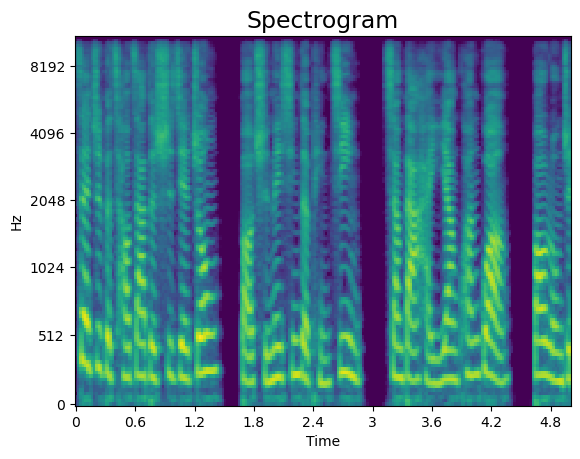

In [70]:
audio, sr = load_audio(r"output_9.wav", sr=SAMPLE_RATE)
print(len(audio))
audio = audio[:AUDIO_LEN]

spec = get_mel_spectrogram(audio)
print(spec[:,0])
print(spec.shape)

fig = plot_mel_spectrogram(spec)
plt.title("Spectrogram", fontsize=17)
plt.show()

# Save audio data to text file
def save_audio_to_txt(audio, filename):
    np.savetxt(filename, audio, fmt='%f')

save_audio_to_txt(audio, 'Librosa_AUDIO_DATA_output_9.txt')

# Save mel spectrogram to text file
def save_spectrogram_to_txt(spec, filename):
    np.savetxt(filename, spec, fmt='%f')

save_spectrogram_to_txt(spec, 'Librosa_SPECTROGRAM_DATA_output_9.txt')

From C++ code, plot by "mel_spectrogra_output_9.txt" file
(128, 216)


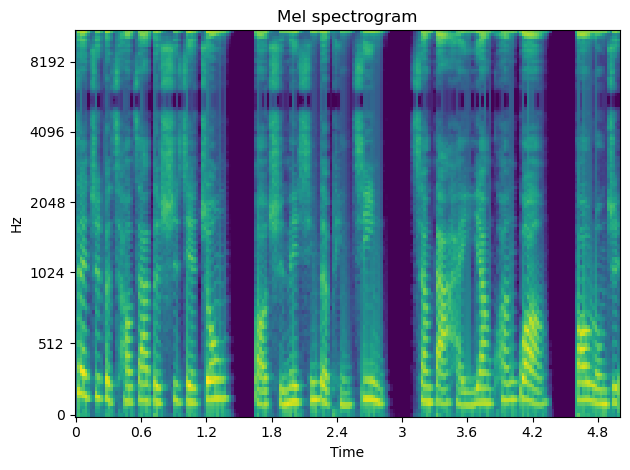

In [71]:
# Example usage
file_path = 'mel_spectrogra_output_9.txt'  # Replace with your actual file path
print(f"From C++ code, plot by \"{file_path}\" file")
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

### old sr hop_length

248063
[ -0.7713156  -9.343118  -15.392981  -19.144066  -20.350904  -22.288574
 -23.424751  -24.643177  -26.130184  -26.644678  -27.59197   -28.055946
 -28.667942  -29.911432  -30.254908  -31.036224  -31.82498   -31.931581
 -32.677265  -33.595345  -32.99894   -34.210632  -34.65043   -34.88077
 -34.77746   -35.823723  -35.694077  -36.89989   -35.221363  -35.378525
 -36.853012  -37.02373   -37.273582  -37.493248  -36.974903  -37.7761
 -38.61353   -38.66204   -39.226456  -38.46344   -38.53279   -39.586372
 -39.1112    -39.752724  -40.95383   -40.14345   -40.16449   -41.466526
 -42.115532  -41.7817    -43.024788  -41.58442   -41.90457   -40.041275
 -40.7226    -41.841843  -42.414436  -43.15474   -42.592316  -42.57961
 -42.947426  -44.13048   -44.214405  -44.315228  -44.246986  -44.968178
 -45.485264  -45.68262   -44.672752  -45.188034  -45.32948   -46.101936
 -46.280384  -45.985302  -46.130985  -47.043663  -47.92196   -47.693413
 -47.946644  -47.46543   -48.260475  -48.392544  -48.53188   

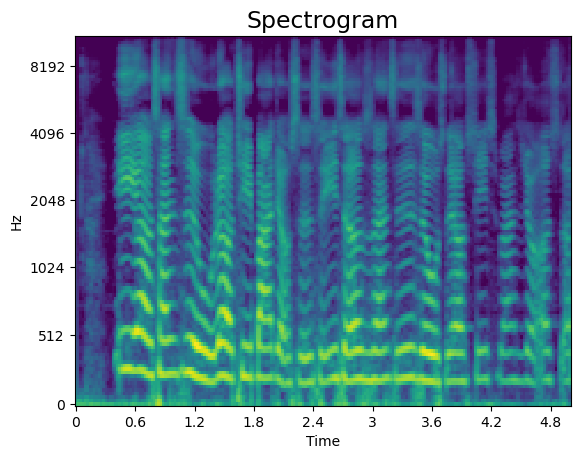

In [72]:
audio, sr = load_audio(r"output.wav", sr=SAMPLE_RATE)
print(len(audio))
audio = audio[:AUDIO_LEN]
# rn_audio = denoise(audio, sr=SAMPLE_RATE)
# delete the low energy part
# mask, _ = envelope(rn_audio, sr, threshold = 0.0005)  # can adjust the threshold
# audio = audio[mask]
spec = get_mel_spectrogram(audio)
print(spec[:, 0])
print(spec.shape)

fig = plot_mel_spectrogram(spec)
plt.title("Spectrogram", fontsize=17)
plt.show()

(128, 216)


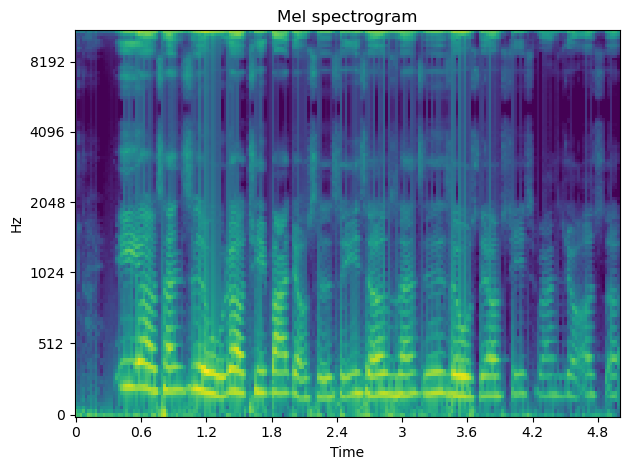

In [73]:
# Example usage
file_path = 'mel_spectrogram.txt'  # Replace with your actual file path
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

8/29 New try - 分段音檔測試畫圖

In [74]:
def see_mel_spec_segments(audio_path, sr=SAMPLE_RATE):
    audio, sr = load_audio(audio_path, sr)
    segment_duration = 5  # Segment duration in seconds
    # Split audio into segments of 5 seconds
    num_segments = math.ceil(len(audio) / (segment_duration * sr))
    # print("num_segments", num_segments)

    for i in range(num_segments):
            start_sample = i * segment_duration * sr
            end_sample = min(start_sample + segment_duration * sr, len(audio))
            audio_segment = audio[start_sample:end_sample]
                
            # pad the audio with the original audio or cut the audio
            if len(audio_segment) < AUDIO_LEN:
                length_audio = len(audio_segment)
                repeat_count = (AUDIO_LEN + length_audio - 1) // length_audio  # Calculate the `ceiling` of AUDIO_LEN / length_audio
                audio_segment = np.tile(audio_segment, repeat_count)[:AUDIO_LEN]  # Repeat and cut to the required length
            

            # Generate the mel spectrogram
            spec = get_mel_spectrogram(audio_segment)
                
            # Plot the mel spectrogram
            plot_mel_spectrogram(spec)
            print(f"Spectrogram Segment {i+1}")
            plt.title(f"Spectrogram Segment {i+1}", fontsize=17)
                
            # Save the spectrogram image with a meaningful filename
            plt.show()

1. `ElevenLabs_2024-06-28T14_36_39_Daniel.mp3`

Spectrogram Segment 1


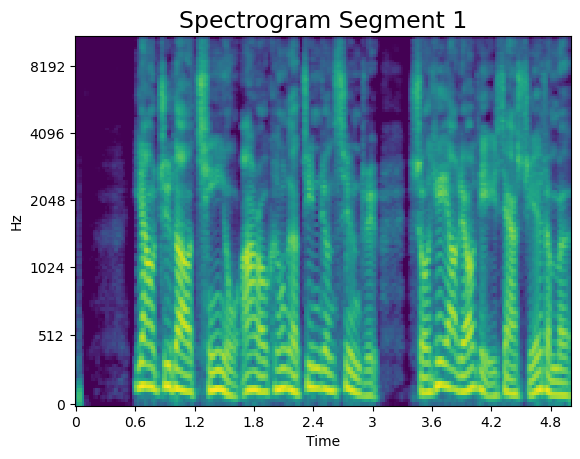

Spectrogram Segment 2


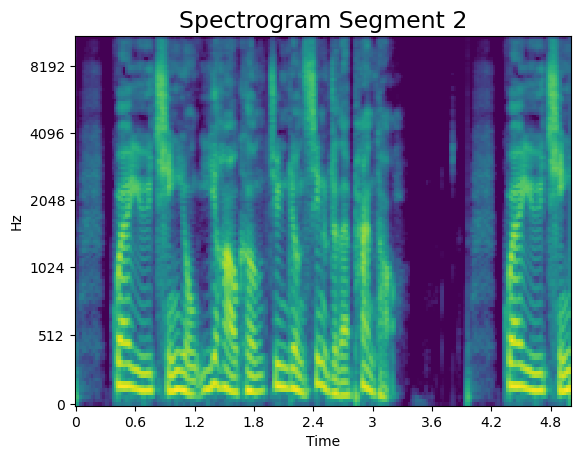

In [75]:
see_mel_spec_segments(r"ElevenLabs_2024-06-28T14_36_39_Daniel.mp3", sr=SAMPLE_RATE)

Plot mel_spectrogram_ElevenLab_seg1.txt
(128, 216)


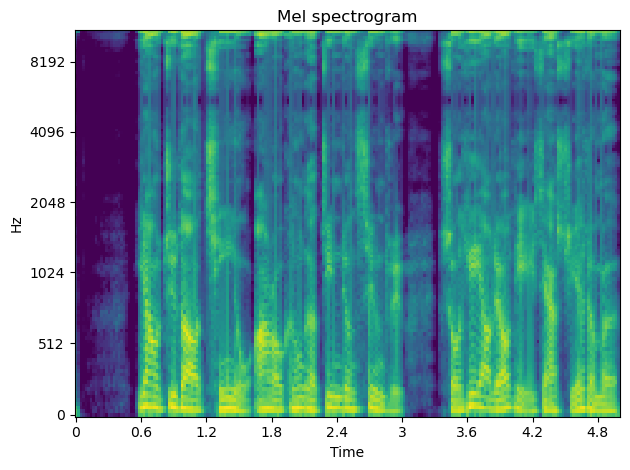

In [76]:
# Example usage
file_path = 'mel_spectrogram_ElevenLab_seg1.txt'  # Replace with your actual file path
print(f"Plot {file_path}")
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

Plot mel_spectrogram_ElevenLab_seg2.txt
(128, 216)


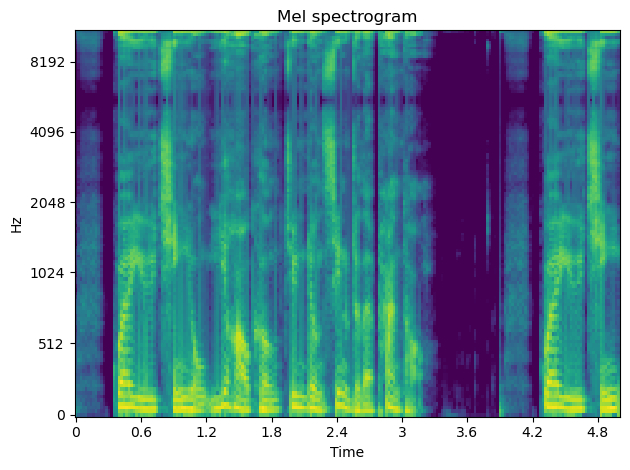

In [77]:
# Example usage
file_path = 'mel_spectrogram_ElevenLab_seg2.txt'  # Replace with your actual file path
print(f"Plot {file_path}")
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

2. `Ann_test_video_processed.wav`

Spectrogram Segment 1


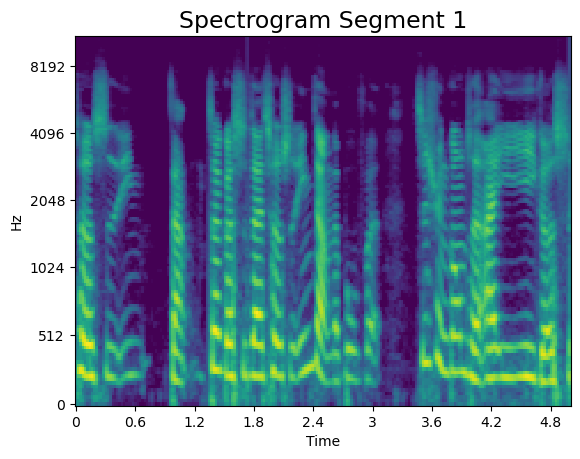

Spectrogram Segment 2


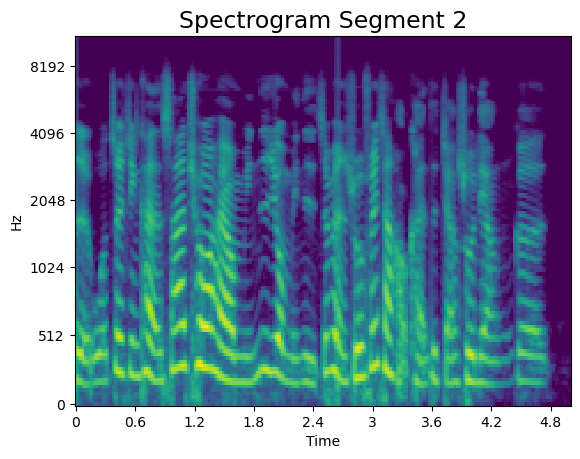

Spectrogram Segment 3


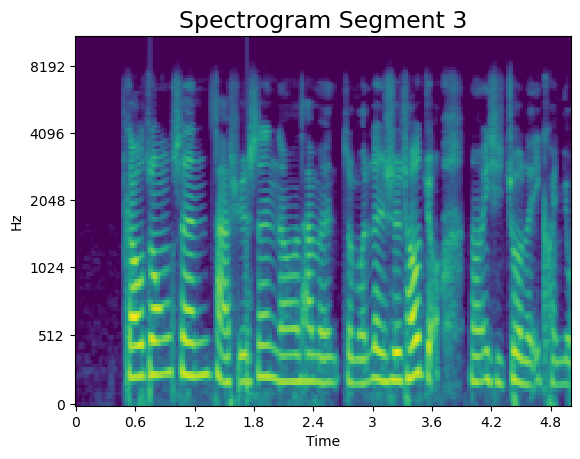

Spectrogram Segment 4


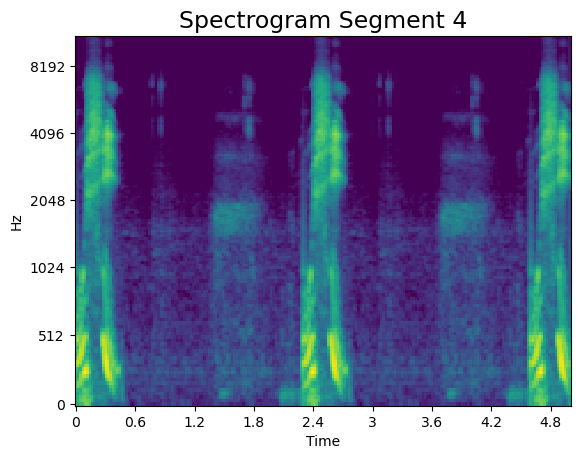

In [78]:
see_mel_spec_segments(r"Ann_test_video_processed.wav", sr=SAMPLE_RATE)

(128, 216)


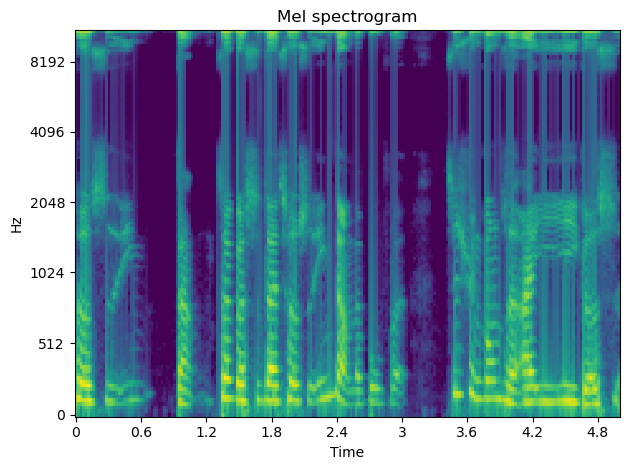

In [79]:
# Example usage
file_path = 'mel_spectrogram_Ann_seg1.txt'  # Replace with your actual file path
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

(128, 216)


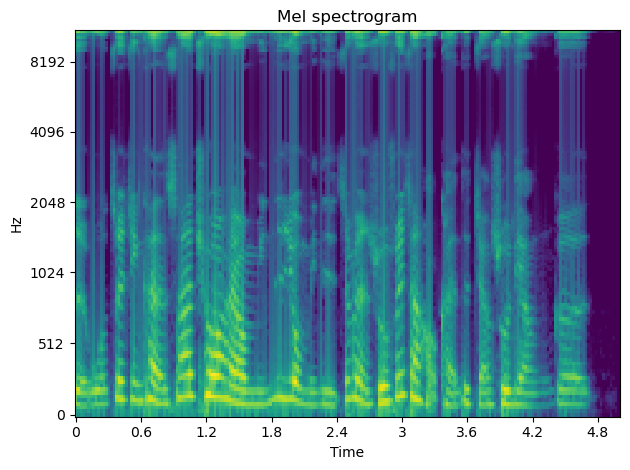

In [80]:
# Example usage
file_path = 'mel_spectrogram_Ann_seg2.txt'  # Replace with your actual file path
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

(128, 216)


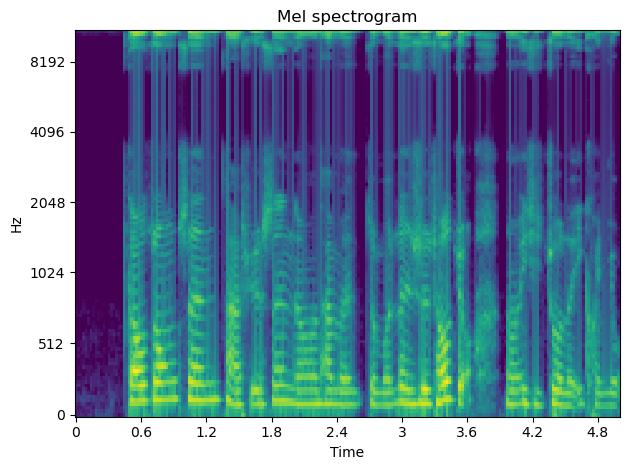

In [81]:
# Example usage
file_path = 'mel_spectrogram_Ann_seg3.txt'  # Replace with your actual file path
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

(128, 216)


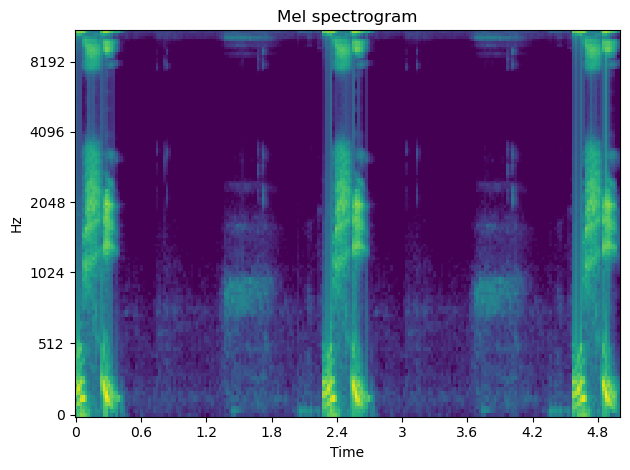

In [82]:
# Example usage
file_path = 'mel_spectrogram_Ann_seg4.txt'  # Replace with your actual file path
mel_spec = read_mel_spectrogram_from_txt(file_path)
plot_mel_spectrogram_txt(mel_spec)

9/1 測試楊的程式畫出來的圖

* test on `ElevenLabs_2024-06-28T14_36_39_Daniel.mp3`

In [83]:
# Function to read Mel spectrogram from .txt file
def new_read_mel_spectrogram_from_txt(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        mel_spec = []
        for line in lines:
            mel_spec.extend([float(value) for value in line.split()])
    # Assuming the Mel spectrogram was stored in a flattened 1D array
    num_mels = N_MELS  # or your actual number of Mel bands
    num_frames = len(mel_spec) // num_mels
    # mel_spec = np.array(mel_spec).reshape((num_frames, num_mels))

    mel_spec = np.array(mel_spec).reshape((num_mels, num_frames))
    print(mel_spec.shape)
    return mel_spec

# Function to plot Mel spectrogram
def new_plot_mel_spectrogram(spec, sr=SAMPLE_RATE, hop_length=HOP_LEN, fmax=FMAX):
    # plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, x_axis='time', y_axis='mel', hop_length=HOP_LEN, sr=sr, fmax=FMAX, cmap='viridis')
    # plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

Plot yang_mel_spectrogram_ElevenLab_seg1.txt
(128, 216)


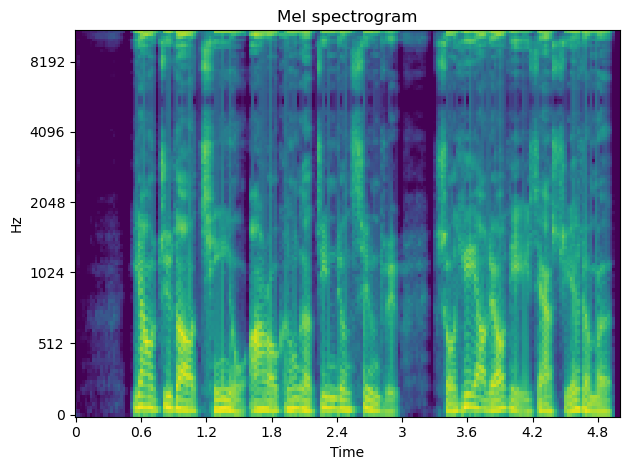

In [84]:
# Example usage
file_path = 'yang_mel_spectrogram_ElevenLab_seg1.txt'  # Replace with your actual file path
print(f"Plot {file_path}")
mel_spec = new_read_mel_spectrogram_from_txt(file_path)
new_plot_mel_spectrogram(mel_spec)

Plot yang_mel_spectrogram_ElevenLab_seg2.txt
(128, 216)


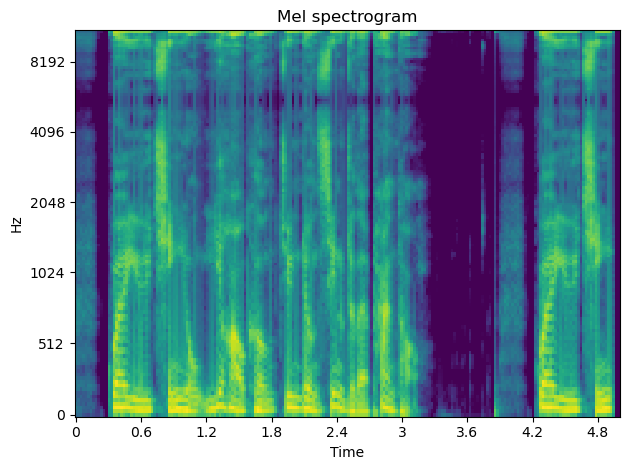

In [85]:
# Example usage
file_path = 'yang_mel_spectrogram_ElevenLab_seg2.txt'  # Replace with your actual file path
print(f"Plot {file_path}")
mel_spec = new_read_mel_spectrogram_from_txt(file_path)
new_plot_mel_spectrogram(mel_spec)

* test on `Ann_test_video_processed.wav`

Plot yang_mel_spectrogram_Ann_seg1.txt
(128, 216)


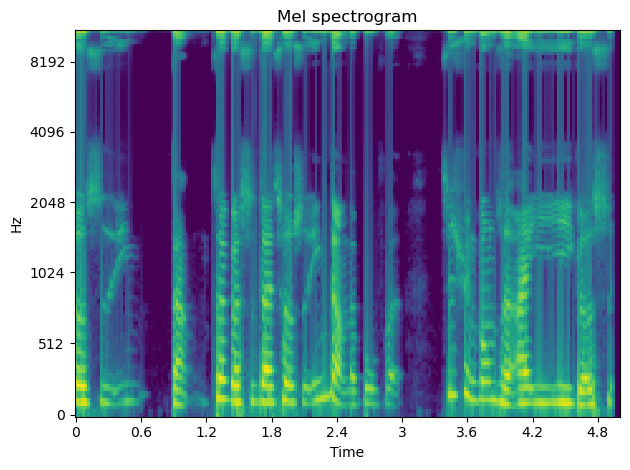

In [86]:
# Example usage
file_path = 'yang_mel_spectrogram_Ann_seg1.txt'  # Replace with your actual file path
print(f"Plot {file_path}")
mel_spec = new_read_mel_spectrogram_from_txt(file_path)
new_plot_mel_spectrogram(mel_spec)

Plot yang_mel_spectrogram_Ann_seg2.txt
(128, 216)


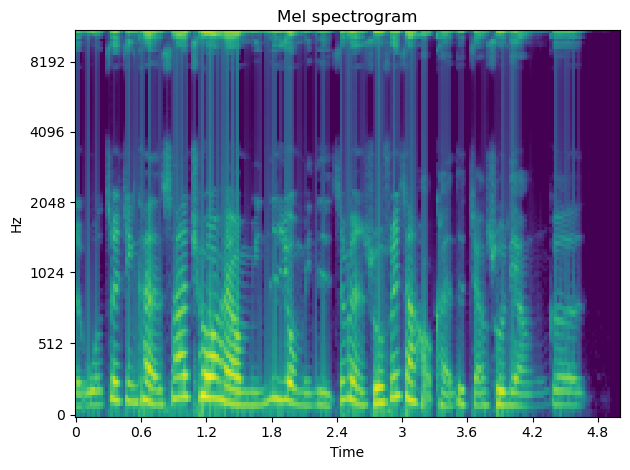

In [87]:
# Example usage
file_path = 'yang_mel_spectrogram_Ann_seg2.txt'  # Replace with your actual file path
print(f"Plot {file_path}")
mel_spec = new_read_mel_spectrogram_from_txt(file_path)
new_plot_mel_spectrogram(mel_spec)

Plot yang_mel_spectrogram_Ann_seg3.txt
(128, 216)


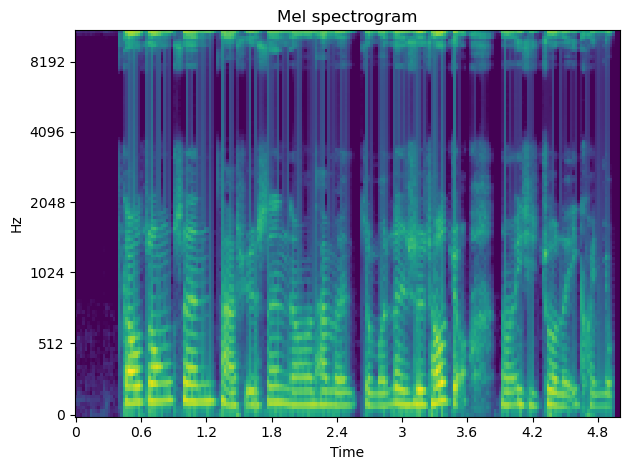

In [88]:
# Example usage
file_path = 'yang_mel_spectrogram_Ann_seg3.txt'  # Replace with your actual file path
print(f"Plot {file_path}")
mel_spec = new_read_mel_spectrogram_from_txt(file_path)
new_plot_mel_spectrogram(mel_spec)

Plot yang_mel_spectrogram_Ann_seg4.txt
(128, 216)


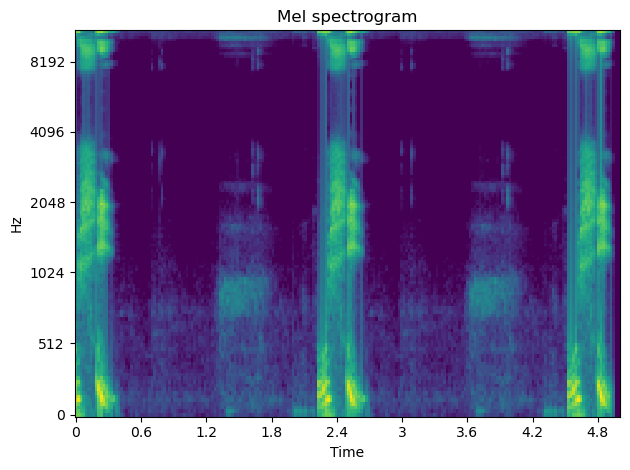

In [89]:
# Example usage
file_path = 'yang_mel_spectrogram_Ann_seg4.txt'  # Replace with your actual file path
print(f"Plot {file_path}")
mel_spec = new_read_mel_spectrogram_from_txt(file_path)
new_plot_mel_spectrogram(mel_spec)